In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.python.data import Dataset
from sklearn import metrics
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
from matplotlib import pyplot as plt

In [2]:
#Read the dataset and shuffle the data
california_data = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_data = california_data.reindex(np.random.permutation(california_data.index))
california_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [4]:
def preprocess_features(data):
    selected_features = data[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
                              'population','households','median_income']]
    processed_features = selected_features.copy()
    processed_features['rooms_per_person'] = (processed_features['total_rooms']/processed_features['population'])
    return processed_features

def preprocess_targets(data):
    processed_targets = pd.DataFrame()
    processed_targets['is_value_high'] = (data['median_house_value'] > 265000).astype(float)
    return processed_targets


In [5]:
training_examples = preprocess_features(california_data.head(12000))
training_targets = preprocess_targets(california_data.head(12000))
validation_examples = preprocess_features(california_data.tail(5000))
validation_targets = preprocess_targets(california_data.tail(5000))

In [6]:
print(training_examples.describe())
print(validation_examples.describe())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
count    12000.0   12000.0             12000.0      12000.0         12000.0   
mean      -119.6      35.6                28.7       2633.3           537.5   
std          2.0       2.1                12.6       2170.9           420.2   
min       -124.3      32.5                 1.0          2.0             1.0   
25%       -121.8      33.9                18.0       1457.0           296.0   
50%       -118.5      34.2                29.0       2119.5           433.0   
75%       -118.0      37.7                37.0       3137.0           647.0   
max       -114.3      42.0                52.0      32627.0          6445.0   

       population  households  median_income  rooms_per_person  
count     12000.0     12000.0        12000.0           12000.0  
mean       1425.0       499.5            3.9               2.0  
std        1123.2       382.4            1.9               1.2  
min           6.0         1.

In [7]:
training_targets.tail()
validation_targets.head()

,is_value_high
7571,1.0
14459,0.0
2312,0.0
5638,0.0
10213,0.0


In [8]:
def get_quantile_based_boundaries(input_feature,num_bkt):
    boundaries = np.arange(1.0,num_bkt)/num_bkt
    quantiles = input_feature.quantile(boundaries)
    return [quantiles[i] for i in quantiles.keys()]

def construct_feature_columns():
    longitude = tf.feature_column.numeric_column('longitude')
    latitude = tf.feature_column.numeric_column('latitude')
    housing_median_age = tf.feature_column.numeric_column('housing_median_age')
    median_income = tf.feature_column.numeric_column('median_income')
    rooms_per_person = tf.feature_column.numeric_column('rooms_per_person')
    
    bucketized_longitude = tf.feature_column.bucketized_column(longitude, boundaries = get_quantile_based_boundaries(training_examples['longitude'],10))
    bucketized_latitude = tf.feature_column.bucketized_column(latitude, boundaries = get_quantile_based_boundaries(training_examples['latitude'],10))
    bucketized_median_age = tf.feature_column.bucketized_column(housing_median_age, boundaries = get_quantile_based_boundaries(training_examples['housing_median_age'],7))
    bucketized_median_income = tf.feature_column.bucketized_column(median_income, boundaries = get_quantile_based_boundaries(training_examples['median_income'],7))
    buckeized_rooms_per_person = tf.feature_column.bucketized_column(rooms_per_person, boundaries = get_quantile_based_boundaries(training_examples['rooms_per_person'],7))
    latxlong = tf.feature_column.crossed_column(set([bucketized_longitude,bucketized_latitude]), hash_bucket_size=1000)
    
    feature_columns = set([bucketized_longitude, bucketized_latitude, bucketized_median_age, buckeized_rooms_per_person, latxlong])
    return feature_columns
    

In [9]:
def input_fn(feature_values, targets, shuffle = True, num_epochs = None, batch_size = 1):
    feature_values = {key:np.array(values) for key, values in dict(feature_values).items()}
    ds = Dataset.from_tensor_slices((feature_values,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


In [10]:
def train_model(training_examples, training_targets, validation_examples, validation_targets,
               steps, learning_rate, batch_size, L1):
    #configure a linear classifier model
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=L1)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(), optimizer=my_optimizer)
    
    #define input functions
    training_input_fn = lambda: input_fn(training_examples, training_targets['is_value_high'])
    training_prediction_fn = lambda: input_fn(training_examples, training_targets['is_value_high'], shuffle = False, num_epochs = 1)
    validation_prediction_fn = lambda: input_fn(validation_examples, validation_targets['is_value_high'], shuffle = False, num_epochs = 1)
    periods = 10
    steps_per_period = steps/periods
    training_loss = []
    validation_loss = []
    for period in range(1,periods):
        print('Training on period', period)
        linear_classifier.train(input_fn = training_input_fn, steps = steps_per_period)
        #take a break and compute predictions
        training_probabilities = linear_classifier.predict(input_fn = training_prediction_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        
        validation_probabilities = linear_classifier.predict(input_fn = validation_prediction_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        
        training_log_loss = metrics.log_loss(training_targets,training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets,validation_probabilities)
        print('training_log_loss %0.2f for the period: %02d', (training_log_loss, period))
        print('validation_log_loss %0.2f for the period %02d: ', (validation_log_loss, period))
        training_loss.append(training_log_loss)
        validation_loss.append(validation_log_loss)
    print('Model training finished')
    print('training_loss: ', training_loss)
    print('validation_loss: ', validation_loss)
    return linear_classifier


        
        
    

In [11]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

In [12]:
linear_classifier = train_model(training_examples = training_examples,
            training_targets = training_targets,
            validation_examples = validation_examples,
            validation_targets = validation_targets,
            steps = 500,
            learning_rate = 0.07,
            batch_size = 1,
            L1 = 0.3
           )
evaluation_metrics = linear_classifier.evaluate(input_fn=validation_prediction_fn)
print('Accuracy and AUC', (evaluation_metrics['accuracy'],evaluation_metrics['auc']))
print ('Model weight: ', model_size(linear_classifier))

Training on period 1
training_log_loss %0.2f for the period: %02d (0.5675069506739576, 1)
validation_log_loss %0.2f for the period %02d:  (0.562770067447424, 1)
Training on period 2
training_log_loss %0.2f for the period: %02d (0.544873151148359, 2)
validation_log_loss %0.2f for the period %02d:  (0.5384198360800743, 2)
Training on period 3
training_log_loss %0.2f for the period: %02d (0.5374355623461307, 3)
validation_log_loss %0.2f for the period %02d:  (0.5300158492937684, 3)
Training on period 4
training_log_loss %0.2f for the period: %02d (0.5347222262993455, 4)
validation_log_loss %0.2f for the period %02d:  (0.526600610871613, 4)
Training on period 5
training_log_loss %0.2f for the period: %02d (0.5341512265857309, 5)
validation_log_loss %0.2f for the period %02d:  (0.5254665961563587, 5)
Training on period 6
training_log_loss %0.2f for the period: %02d (0.5347164964691425, 6)
validation_log_loss %0.2f for the period %02d:  (0.5255441394820809, 6)
Training on period 7
training_l

NameError: name 'validation_prediction_fn' is not defined

In [13]:
validation_prediction_fn = lambda: input_fn(validation_examples, validation_targets['is_value_high'], shuffle = False, num_epochs = 1)

In [15]:
evaluation_metrics = linear_classifier.evaluate(input_fn=validation_prediction_fn)
print('Accuracy and AUC', (evaluation_metrics['accuracy'],evaluation_metrics['auc']))
print ('Model weight: ', model_size(linear_classifier))

Accuracy and AUC (0.7726, 0.65045714)
Model weight:  58


[0.00000000e+00 0.00000000e+00 2.65111347e-04 2.65111347e-04
 1.32555673e-03 1.32555673e-03 1.32555673e-03 6.36267232e-03
 6.36267232e-03 7.68822906e-03 8.21845175e-03 8.48356310e-03
 9.01378579e-03 1.27253446e-02 1.29904560e-02 1.35206787e-02
 1.88229056e-02 2.62460233e-02 2.67762460e-02 2.73064687e-02
 2.91622481e-02 2.99575822e-02 2.99575822e-02 3.44644751e-02
 3.65853659e-02 4.18875928e-02 5.85896076e-02 5.85896076e-02
 6.52173913e-02 6.52173913e-02 7.84729586e-02 9.25238600e-02
 9.35843054e-02 9.43796394e-02 9.83563097e-02 9.91516437e-02
 9.94167550e-02 9.94167550e-02 1.03393425e-01 1.05779427e-01
 1.06309650e-01 1.07635207e-01 1.08695652e-01 1.34411453e-01
 1.43690350e-01 1.67020148e-01 1.67020148e-01 1.70996819e-01
 1.75238600e-01 1.75503712e-01 1.76564157e-01 1.79480382e-01
 1.80010604e-01 1.85577943e-01 1.89024390e-01 1.91675504e-01
 1.92735949e-01 1.93001060e-01 1.94326617e-01 1.94856840e-01
 1.98568399e-01 2.09437964e-01 2.11823966e-01 2.17656416e-01
 2.20042418e-01 2.295864

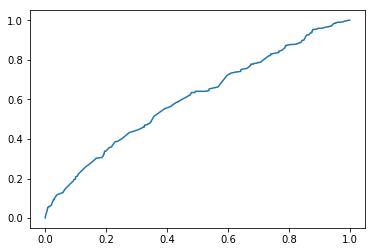

In [51]:
#plot roc from class probabilities
validation_probabilities = linear_classifier.predict(input_fn=validation_prediction_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])
FPR, TPR, thresholds = metrics.roc_curve(validation_targets, validation_probabilities)
#print(FPR,TPR, thresholds)
plt.plot(FPR,TPR, label = 'my_model')